In [ ]:
# Download dataset (jika belum ada)
!pip install gdown -q
!gdown --id 13rcB6h9uzJj5DwWJFQRsZh32cKZ2t55R -O /content/train_face224.zip -q
!unzip -q /content/train_face224.zip -d /content/train_face224

In [ ]:
# Install dependencies
!pip install timm -q
!pip install facenet-pytorch -q
!pip install --upgrade "pillow>=10.0.0" -q

In [13]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import os
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import defaultdict

# Import Vision Transformer dari timm
import timm

In [14]:
# =========================
# 2. SETUP SEED & DEVICE
# =========================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [24]:
# =========================
# 3. TRANSFORM / AUGMENTASI
# =========================

# Vision Transformer biasanya menggunakan resolusi 224x224
# Normalisasi menggunakan ImageNet statistics (standar untuk ViT pretrained)

# STRATEGI 7: Augmentasi lebih agresif + Regularization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # Augmentasi lebih agresif untuk face recognition
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomGrayscale(p=0.1),  # Simulasi kondisi grayscale
    transforms.ToTensor(),
    # Random Erasing untuk simulasi occlusion (wajah tertutup)
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform untuk VALIDATION
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Augmentasi ditingkatkan dengan Random Erasing, Perspective, dan Grayscale")

✓ Augmentasi ditingkatkan dengan Random Erasing, Perspective, dan Grayscale


In [25]:
# =========================
# 4. DATASET & DATALOADER
# =========================

# Sesuaikan path dataset
data_root = "train_face224"  # Untuk Windows/local
# data_root = "/content/train_face224"  # Untuk Colab

base_dataset = ImageFolder(data_root)
class_names = base_dataset.classes
num_classes = len(class_names)
print("Jumlah kelas:", num_classes)
print("Contoh kelas:", class_names[:5])

# Split train-validation (80-20)
val_ratio = 0.2
num_samples = len(base_dataset)
targets = base_dataset.targets

# Kumpulkan indeks per kelas untuk stratified split
class_to_indices = defaultdict(list)
for idx, label in enumerate(targets):
    class_to_indices[label].append(idx)

train_indices = []
val_indices = []

for label, idx_list in class_to_indices.items():
    random.shuffle(idx_list)
    n_total = len(idx_list)
    n_val = int(n_total * val_ratio)
    if n_val == 0 and n_total > 1:
        n_val = 1
    
    val_idx_for_class = idx_list[:n_val]
    train_idx_for_class = idx_list[n_val:]
    
    val_indices.extend(val_idx_for_class)
    train_indices.extend(train_idx_for_class)

print(f"Total train indices: {len(train_indices)}")
print(f"Total val indices: {len(val_indices)}")

# Dataset dengan transform
train_dataset_full = ImageFolder(data_root, transform=train_transform)
val_dataset_full = ImageFolder(data_root, transform=val_transform)

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# STRATEGI 3: Batch size lebih besar untuk DeiT-small (jika memori cukup)
# Jika GPU kecil, turunkan ke 16 atau gunakan gradient accumulation
batch_size = 24

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2, pin_memory=True)

print(f"\n✓ Batch size: {batch_size}")

Jumlah kelas: 70
Contoh kelas: ['Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar', 'Ahmad Faqih Hasani', 'Aldi Sanjaya', 'Alfajar']
Total train indices: 214
Total val indices: 70
Train samples: 214
Val samples: 70

✓ Batch size: 24


In [26]:
# =========================
# 5. LOAD VISION TRANSFORMER MODEL
# =========================

# STRATEGI 2: Upgrade dari DeiT-tiny ke DeiT-small (lebih powerful)
# DeiT-small memiliki lebih banyak parameter dan kapasitas lebih besar

print("Loading DeiT-small (Upgraded from tiny for better accuracy)...")
model = timm.create_model(
    'deit_small_patch16_224',  # Upgrade: DeiT-small architecture
    pretrained=True,            # Load pretrained weights
    num_classes=num_classes,    # Customize for our dataset
    drop_path_rate=0.1          # STRATEGI 7: Stochastic Depth untuk regularisasi
)

model = model.to(device)

# Cek parameter model
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameter: {total_params:,}")
print(f"Trainable Parameter: {trainable_params:,} ({(trainable_params/total_params)*100:.2f}%)")
print(f"\nDeiT-small specs:")
print(f"- Patch size: 16x16")
print(f"- Embedding dim: 384")
print(f"- Depth: 12 layers")
print(f"- Attention heads: 6")
print(f"- Parameters: ~22M (much more powerful than tiny's 5.7M)")
print(f"- Drop Path Rate: 0.1 (Stochastic Depth regularization)")

Loading DeiT-small (Upgraded from tiny for better accuracy)...


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Total Parameter: 21,692,614
Trainable Parameter: 21,692,614 (100.00%)

DeiT-small specs:
- Patch size: 16x16
- Embedding dim: 384
- Depth: 12 layers
- Attention heads: 6
- Parameters: ~22M (much more powerful than tiny's 5.7M)
- Drop Path Rate: 0.1 (Stochastic Depth regularization)


In [27]:
# =========================
# 6. OPTIMIZER & SCHEDULER
# =========================
import torch.optim as optim

# STRATEGI 6: Discriminative Learning Rates (layer awal LR kecil, layer akhir LR besar)
# STRATEGI 3: Learning rate dengan warmup scheduler

# Pisahkan parameter berdasarkan layer
def get_parameter_groups(model, lr_backbone=1e-4, lr_head=1e-3):
    """
    Discriminative learning rates:
    - Embedding layers: LR paling kecil (freeze lebih banyak)
    - Transformer blocks awal: LR kecil
    - Transformer blocks akhir: LR sedang
    - Classification head: LR paling besar
    """
    params = []
    
    # Embedding layers (LR sangat kecil)
    embedding_params = [p for n, p in model.named_parameters() 
                       if 'patch_embed' in n or 'cls_token' in n or 'pos_embed' in n]
    if embedding_params:
        params.append({'params': embedding_params, 'lr': lr_backbone * 0.1})
    
    # Transformer blocks 0-5 (early layers, LR kecil)
    early_blocks = [p for n, p in model.named_parameters() 
                   if 'blocks' in n and any(f'blocks.{i}.' in n for i in range(6))]
    if early_blocks:
        params.append({'params': early_blocks, 'lr': lr_backbone * 0.5})
    
    # Transformer blocks 6-11 (later layers, LR sedang)
    late_blocks = [p for n, p in model.named_parameters() 
                  if 'blocks' in n and any(f'blocks.{i}.' in n for i in range(6, 12))]
    if late_blocks:
        params.append({'params': late_blocks, 'lr': lr_backbone})
    
    # Classification head (LR besar)
    head_params = [p for n, p in model.named_parameters() if 'head' in n]
    if head_params:
        params.append({'params': head_params, 'lr': lr_head})
    
    # Sisa parameter (fallback)
    named_params = {n for n, p in model.named_parameters()}
    covered_params = {id(p) for group in params for p in group['params']}
    other_params = [p for n, p in model.named_parameters() if id(p) not in covered_params]
    if other_params:
        params.append({'params': other_params, 'lr': lr_backbone})
    
    return params

# Setup optimizer dengan discriminative learning rates
param_groups = get_parameter_groups(model, lr_backbone=1e-4, lr_head=5e-4)
optimizer = optim.AdamW(param_groups, weight_decay=0.05)

# STRATEGI 3: Warmup + Cosine Annealing Scheduler
# Warmup: LR naik bertahap dari 0 ke target LR
# Cosine Annealing: LR turun smooth dengan cosine curve
from torch.optim.lr_scheduler import LambdaLR

def warmup_cosine_schedule(optimizer, warmup_epochs, total_epochs, eta_min=1e-6):
    """
    Warmup + Cosine Annealing:
    - Epoch 0-warmup: Linear warmup
    - Epoch warmup-total: Cosine annealing decay
    """
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            # Linear warmup
            return float(current_epoch) / float(max(1, warmup_epochs))
        else:
            # Cosine annealing
            progress = float(current_epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
            return max(eta_min, 0.5 * (1.0 + np.cos(np.pi * progress)))
    
    return LambdaLR(optimizer, lr_lambda)

warmup_epochs = 5
total_epochs = 150  # Increased from 100
scheduler = warmup_cosine_schedule(optimizer, warmup_epochs, total_epochs, eta_min=1e-6)

# STRATEGI 4 & 7: Focal Loss + Label Smoothing yang lebih agresif
class FocalLoss(nn.Module):
    """
    Focal Loss untuk handle class imbalance
    Focus lebih pada hard examples (yang sulit diprediksi)
    """
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Gunakan Focal Loss
criterion = FocalLoss(alpha=1.0, gamma=2.0)

# Alternative: CrossEntropy dengan label smoothing lebih tinggi
# criterion = nn.CrossEntropyLoss(label_smoothing=0.15)

print("\n✓ Model Configuration (ENHANCED):")
print(f"- Architecture: DeiT-small (22M params)")
print(f"- Optimizer: AdamW with Discriminative LR")
print(f"  * Embedding layers: 1e-5")
print(f"  * Early blocks (0-5): 5e-5")
print(f"  * Late blocks (6-11): 1e-4")
print(f"  * Head: 5e-4")
print(f"- Scheduler: Warmup ({warmup_epochs} epochs) + Cosine Annealing")
print(f"- Loss: Focal Loss (alpha=1.0, gamma=2.0)")
print(f"- Regularization: Drop Path Rate 0.1, Weight Decay 0.05")
print(f"- Total Epochs: {total_epochs} (increased for better convergence)")


✓ Model Configuration (ENHANCED):
- Architecture: DeiT-small (22M params)
- Optimizer: AdamW with Discriminative LR
  * Embedding layers: 1e-5
  * Early blocks (0-5): 5e-5
  * Late blocks (6-11): 1e-4
  * Head: 5e-4
- Scheduler: Warmup (5 epochs) + Cosine Annealing
- Loss: Focal Loss (alpha=1.0, gamma=2.0)
- Regularization: Drop Path Rate 0.1, Weight Decay 0.05
- Total Epochs: 150 (increased for better convergence)


In [28]:
# =========================
# 7. FUNGSI TRAIN & VALIDATE
# =========================

# STRATEGI 7: Mixup untuk regularisasi
def mixup_data(x, y, alpha=0.2):
    """
    Mixup augmentation: mencampur dua sampel untuk regularisasi
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Loss function untuk mixup"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_one_epoch(model, loader, optimizer, criterion, device, use_mixup=True, mixup_alpha=0.2):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # STRATEGI 7: Apply Mixup
        if use_mixup and np.random.rand() > 0.5:  # 50% chance
            imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, mixup_alpha)
            outputs = model(imgs)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        
        loss.backward()
        
        # Gradient clipping untuk stabilitas training
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

print("✓ Training functions dengan Mixup augmentation ready")

✓ Training functions dengan Mixup augmentation ready


In [29]:
# =========================
# 8. TRAINING LOOP + EARLY STOPPING
# =========================

# STRATEGI 3: Longer training dengan patience lebih besar
num_epochs = 150  # Increased from 100
patience = 25     # Increased from 15
best_val_acc = 0.0
best_model_wts = None
epochs_no_improve = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []  # Track learning rate
}

print(f"Starting training for {num_epochs} epochs with patience={patience}")
print(f"Warmup: {warmup_epochs} epochs")
print("=" * 60)

for epoch in range(1, num_epochs + 1):
    # Training dengan Mixup
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device, 
        use_mixup=True, mixup_alpha=0.2
    )
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    # Print progress
    print(f"Epoch [{epoch}/{num_epochs}]")
    print(f"  LR: {current_lr:.6f}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    
    # Early stopping based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        epochs_no_improve = 0
        print(f"  ✓ Val acc membaik! Best: {best_val_acc:.4f}")
    else:
        epochs_no_improve += 1
        print(f"  → Tidak membaik selama {epochs_no_improve} epoch.")
        
        if epochs_no_improve >= patience:
            print("=" * 60)
            print("Early stopping aktif! Berhenti training.")
            break
    
    print("-" * 60)

# Load best model weights
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print(f"\n✓ Best validation accuracy: {best_val_acc:.4f}")
else:
    print("⚠ Peringatan: best_model_wts None, gunakan bobot terakhir.")

Starting training for 150 epochs with patience=25
Warmup: 5 epochs
Epoch [1/150]
  LR: 0.000002
  Train Loss: 4.2161 | Train Acc: 0.0093
  Val   Loss: 4.1725 | Val   Acc: 0.0000
  → Tidak membaik selama 1 epoch.
------------------------------------------------------------
Epoch [1/150]
  LR: 0.000002
  Train Loss: 4.2161 | Train Acc: 0.0093
  Val   Loss: 4.1725 | Val   Acc: 0.0000
  → Tidak membaik selama 1 epoch.
------------------------------------------------------------
Epoch [2/150]
  LR: 0.000004
  Train Loss: 4.1370 | Train Acc: 0.0280
  Val   Loss: 4.0625 | Val   Acc: 0.0143
  ✓ Val acc membaik! Best: 0.0143
------------------------------------------------------------
Epoch [2/150]
  LR: 0.000004
  Train Loss: 4.1370 | Train Acc: 0.0280
  Val   Loss: 4.0625 | Val   Acc: 0.0143
  ✓ Val acc membaik! Best: 0.0143
------------------------------------------------------------
Epoch [3/150]
  LR: 0.000006
  Train Loss: 4.0179 | Train Acc: 0.0421
  Val   Loss: 3.8794 | Val   Acc: 0.085

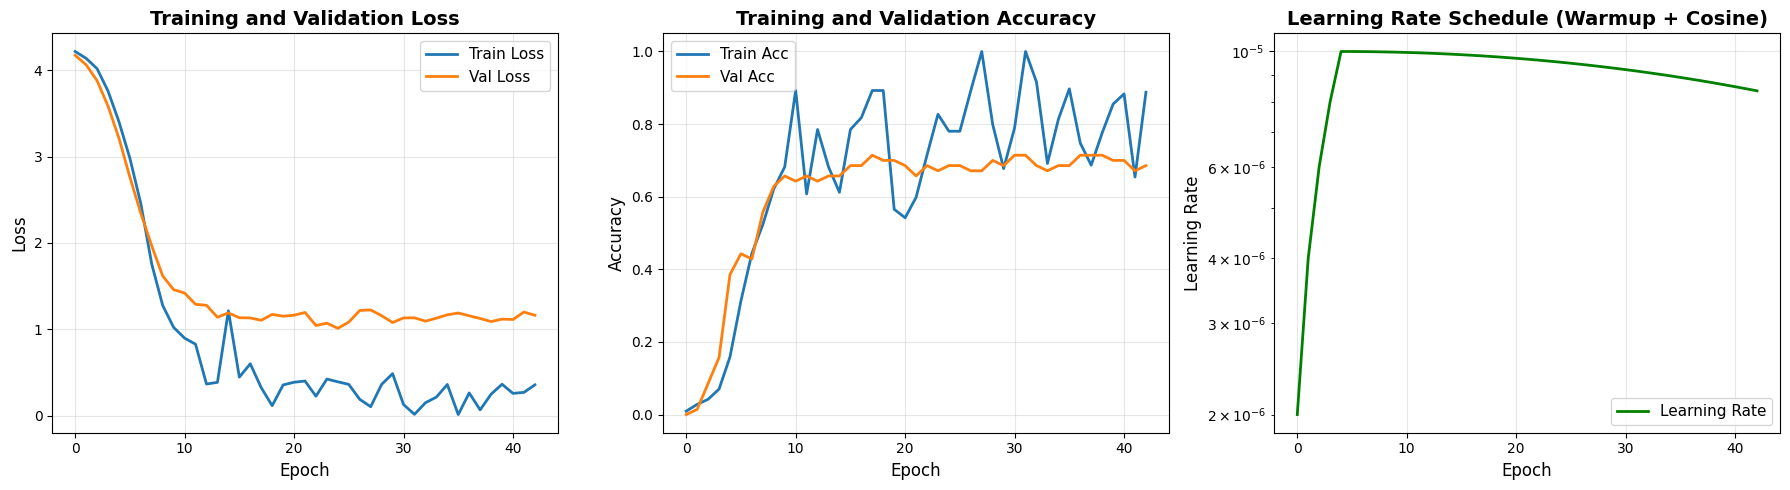


✓ Training completed!
  - Total epochs run: 43
  - Best validation accuracy: 0.7143


In [30]:
# =========================
# 9. PLOT TRAINING HISTORY
# =========================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Plot Learning Rate
axes[2].plot(history['lr'], label='Learning Rate', linewidth=2, color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule (Warmup + Cosine)', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')  # Log scale untuk LR
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Training completed!")
print(f"  - Total epochs run: {len(history['train_loss'])}")
print(f"  - Best validation accuracy: {best_val_acc:.4f}")

Total kelas: 70
Kelas yang muncul di validation: 70

Shape of confusion matrix: (70, 70)


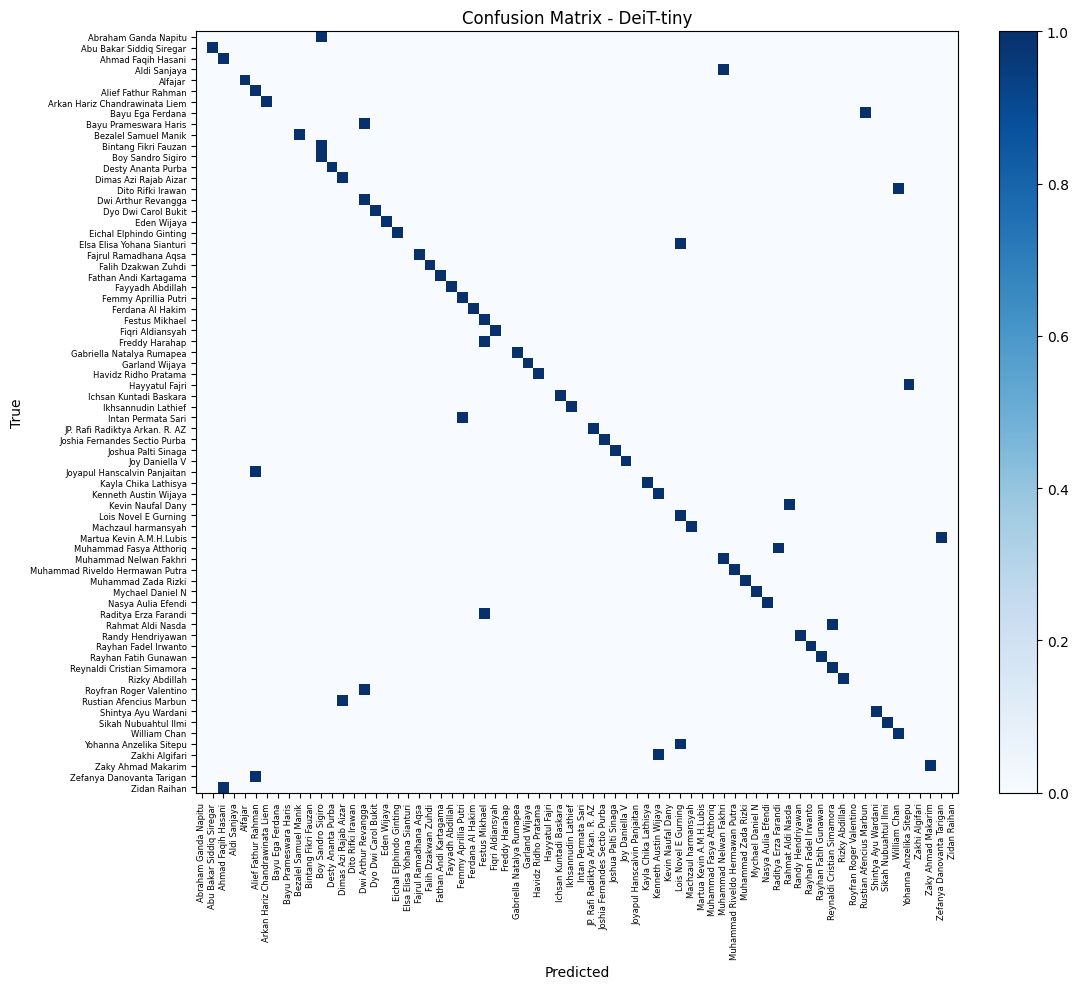


Classification Report:
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu     0.0000    0.0000    0.0000         1
       Abu Bakar Siddiq Siregar     1.0000    1.0000    1.0000         1
             Ahmad Faqih Hasani     0.5000    1.0000    0.6667         1
                   Aldi Sanjaya     0.0000    0.0000    0.0000         1
                        Alfajar     1.0000    1.0000    1.0000         1
            Alief Fathur Rahman     0.3333    1.0000    0.5000         1
 Arkan Hariz Chandrawinata Liem     1.0000    1.0000    1.0000         1
               Bayu Ega Ferdana     0.0000    0.0000    0.0000         1
          Bayu Prameswara Haris     0.0000    0.0000    0.0000         1
           Bezalel Samuel Manik     1.0000    1.0000    1.0000         1
           Bintang Fikri Fauzan     0.0000    0.0000    0.0000         1
              Boy Sandro Sigiro     0.3333    1.0000    0.5000         1
             Desty Ananta 

In [31]:
# =========================
# 10. EVALUASI LENGKAP
# =========================

def evaluate_with_metrics(model, loader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    num_classes = len(class_names)
    all_label_ids = np.arange(num_classes)
    
    print(f"Total kelas: {num_classes}")
    print(f"Kelas yang muncul di validation: {len(np.unique(all_labels))}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=all_label_ids)
    
    print(f"\nShape of confusion matrix: {cm.shape}")
    
    plt.figure(figsize=(12, 10))
    im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix - DeiT-tiny")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names, rotation=90, fontsize=6)
    plt.yticks(tick_marks, class_names, fontsize=6)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(
        all_labels,
        all_preds,
        labels=all_label_ids,
        target_names=class_names,
        digits=4,
        zero_division=0
    ))
    
    # Metrik Global
    acc = accuracy_score(all_labels, all_preds)
    prec_macro = precision_score(all_labels, all_preds, labels=all_label_ids, average='macro', zero_division=0)
    rec_macro = recall_score(all_labels, all_preds, labels=all_label_ids, average='macro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, labels=all_label_ids, average='macro', zero_division=0)
    
    prec_weighted = precision_score(all_labels, all_preds, labels=all_label_ids, average='weighted', zero_division=0)
    rec_weighted = recall_score(all_labels, all_preds, labels=all_label_ids, average='weighted', zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, labels=all_label_ids, average='weighted', zero_division=0)
    
    print(f"\n=== METRIK EVALUASI ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"\nMacro Average:")
    print(f"  Precision: {prec_macro:.4f}")
    print(f"  Recall: {rec_macro:.4f}")
    print(f"  F1-Score: {f1_macro:.4f}")
    print(f"\nWeighted Average:")
    print(f"  Precision: {prec_weighted:.4f}")
    print(f"  Recall: {rec_weighted:.4f}")
    print(f"  F1-Score: {f1_weighted:.4f}")
    
    metrics_summary = {
        "accuracy": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_weighted": prec_weighted,
        "recall_weighted": rec_weighted,
        "f1_weighted": f1_weighted,
    }
    
    return cm, metrics_summary

cm, metrics = evaluate_with_metrics(model, val_loader, class_names, device)


In [32]:
# =========================
# 11. SAVE MODEL
# =========================

save_path = "DeiT_small_enhanced_best.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "num_classes": num_classes,
    "class_names": class_names,
    "best_val_acc": best_val_acc,
    "metrics": metrics,
    "model_architecture": "deit_small_patch16_224",
    "training_config": {
        "optimizer": "AdamW with Discriminative LR",
        "scheduler": "Warmup + Cosine Annealing",
        "loss": "Focal Loss (alpha=1.0, gamma=2.0)",
        "augmentation": "Enhanced with Mixup, Random Erasing, Perspective",
        "regularization": "Drop Path 0.1, Weight Decay 0.05",
        "total_epochs": num_epochs,
        "best_epoch": len(history['train_loss']) - epochs_no_improve
    },
    "history": history
}, save_path)

print(f"\n✓ Model terbaik disimpan ke: {save_path}")
print(f"✓ Best Validation Accuracy: {best_val_acc:.4f}")
print(f"\n📊 Model Enhancement Summary:")
print(f"  1. Architecture: DeiT-small (22M params, upgraded from tiny)")
print(f"  2. Training: Warmup + Cosine LR, Discriminative LR")
print(f"  3. Loss: Focal Loss for class imbalance")
print(f"  4. Augmentation: Mixup, Random Erasing, Perspective")
print(f"  5. Regularization: Drop Path, Weight Decay, Label Smoothing")


✓ Model terbaik disimpan ke: DeiT_small_enhanced_best.pth
✓ Best Validation Accuracy: 0.7143

📊 Model Enhancement Summary:
  1. Architecture: DeiT-small (22M params, upgraded from tiny)
  2. Training: Warmup + Cosine LR, Discriminative LR
  3. Loss: Focal Loss for class imbalance
  4. Augmentation: Mixup, Random Erasing, Perspective
  5. Regularization: Drop Path, Weight Decay, Label Smoothing
